# Requirements 

**1. Build a characterization of a member’s health status based on their outpatient data.** The CCS mapping will be
useful for that. Feel free to define whatever you would consider a useful high-level description of a member's health status - e.g. “Member xyz had cancer and a broken leg.” This does not need to be overly complicated - the challenge lies in finding a robust and useful characterization.

**2. Investigate how to infer this health status from the prescription drug data alone.** By the end of this exercise,
you should have a simple model that could be applied to data for additional members to try to predict their status. It’s up to you as to how you want to build this model. If there is not enough time to build an actual working model, include a plan explaining what you have learned from the data and how you would build a model given additional time.

# Outline

In [1]:
# Libraries
import pandas as pd
import numpy as np
from pandas import merge_asof
# Visualizations
import matplotlib.pyplot as plt
# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MultiLabelBinarizer
import xgboost as xgb
# Misc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Version Control
versions = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "xgboost": xgb.__version__
}

versions

{'pandas': '1.5.3',
 'numpy': '1.24.4',
 'matplotlib': '3.9.0',
 'xgboost': '2.1.1'}

# Load & Explore

In [3]:
ccs_df = pd.read_csv("/Users/adamrivardwalter/Data for Processing/Preprocessing/Data_(Researcher)_Case_Study_Datasets/ccs.csv")
claims_df = pd.read_csv("/Users/adamrivardwalter/Data for Processing/Preprocessing/Data_(Researcher)_Case_Study_Datasets/claim_lines.csv")
rx_df = pd.read_csv("/Users/adamrivardwalter/Data for Processing/Preprocessing/Data_(Researcher)_Case_Study_Datasets/prescription_drugs.csv")

In [4]:
ccs_df.head()

,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
0,A000,"Cholera due to Vibrio cholerae 01, biovar chol...",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
1,A001,"Cholera due to Vibrio cholerae 01, biovar eltor",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
2,A009,"Cholera, unspecified",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
3,A0100,"Typhoid fever, unspecified",Diseases of the digestive system,Intestinal infection [135.],Intestinal infection
4,A0101,Typhoid meningitis,Diseases of the nervous system and sense organs,Central nervous system infection,Meningitis (except that caused by tuberculosis...


In [5]:
ccs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72167 entries, 0 to 72166
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   diag        72167 non-null  object
 1   diag_desc   72167 non-null  object
 2   ccs_1_desc  72167 non-null  object
 3   ccs_2_desc  72167 non-null  object
 4   ccs_3_desc  72167 non-null  object
dtypes: object(5)
memory usage: 2.8+ MB


In [6]:
claims_df.head()

,record_id,member_id,date_svc,diag1
0,57738,M0000001,2015-12-06,N92.6
1,57750,M0000001,2015-12-06,O26.842
2,65072,M0000001,2015-12-13,O26.842
3,201796,M0000001,2016-02-29,O26.843
4,267197,M0000001,2016-03-27,O26.843


In [7]:
claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919983 entries, 0 to 1919982
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   record_id  int64 
 1   member_id  object
 2   date_svc   object
 3   diag1      object
dtypes: int64(1), object(3)
memory usage: 58.6+ MB


In [8]:
rx_df.head()

,record_id,member_id,date_svc,ndc,drug_category,drug_group,drug_class
0,4115084976453758912,M0023556,2016-05-08,51285040702,Estrogens,Estrogens,Estrogens
1,1750642805638674193,M0087538,2016-12-05,50474080303,Antiparkinson and Related Therapy Agents,Antiparkinson Dopaminergics,Nonergoline Dopamine Receptor Agonists
2,5543689263541245391,M0049608,2018-01-18,3089421,Anticoagulants,Direct Factor Xa Inhibitors,Direct Factor Xa Inhibitors
3,5952194046467620061,M0175153,2017-01-28,603580321,Gastrointestinal Agents - Misc.,Inflammatory Bowel Agents,Inflammatory Bowel Agents
4,1809570950798791089,M0152187,2016-05-13,591396501,Progestins,Progestins,Progestins


In [9]:
rx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3005934 entries, 0 to 3005933
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   record_id      int64 
 1   member_id      object
 2   date_svc       object
 3   ndc            int64 
 4   drug_category  object
 5   drug_group     object
 6   drug_class     object
dtypes: int64(2), object(5)
memory usage: 160.5+ MB


# Data Cleaning

In [10]:
print(ccs_df.isnull().sum())
print(claims_df.isnull().sum())
print(rx_df.isnull().sum())

diag          0
diag_desc     0
ccs_1_desc    0
ccs_2_desc    0
ccs_3_desc    0
dtype: int64
record_id     0
member_id     0
date_svc     24
diag1         0
dtype: int64
record_id        0
member_id        0
date_svc         0
ndc              0
drug_category    0
drug_group       0
drug_class       0
dtype: int64


In [11]:
missing_dates = claims_df[claims_df['date_svc'].isnull()]

In [12]:
# flag missing values for future analysis
claims_df['date_missing'] = claims_df['date_svc'].isnull().astype(int)

In [13]:
# convert the date_svc from both claims_df and rx_df to datetime format
claims_df['date_svc'] = pd.to_datetime(claims_df['date_svc'])
rx_df['date_svc'] = pd.to_datetime(rx_df['date_svc'])

# Merge

In [14]:
# used left join since rx_df had multiple records per member_id
merged_df = pd.merge(claims_df, rx_df, on=['member_id', 'date_svc'], how='left')
final_df = pd.merge(merged_df, ccs_df, left_on='diag1', right_on='diag', how='left')

# Data Integrety post-merge

In [15]:
print(f"original claims data: {len(claims_df)} rows")
print(f"merged data: {len(final_df)} rows")

original claims data: 1919983 rows
merged data: 2216623 rows


In [16]:
# check for duplicates after merging
duplicate_check = merged_df.duplicated(subset=['member_id', 'date_svc']).sum()
print(f"Number of duplicate rows: {duplicate_check}")

# count unique records in rx_df
unique_rx_entries = rx_df.groupby(['member_id', 'date_svc']).size().reset_index(name='count')
print(unique_rx_entries.sort_values(by='count', ascending=False).head())

Number of duplicate rows: 592567
        member_id   date_svc  count
1070400  M0146812 2016-01-04     20
1104335  M0151509 2018-02-24     20
1443736  M0197633 2016-08-15     20
1443709  M0197633 2016-04-23     19
1104338  M0151509 2018-03-23     19


**Note: Why do some members have up to 20 prescriptions in a day?**

In [17]:
# check the final number of rows and missing values
print(f"Final Number of Rows: {len(final_df)}")
print(f"Remaining Missing Values: \n{final_df.isnull().sum()}")

Final Number of Rows: 2216623
Remaining Missing Values: 
record_id_x            0
member_id              0
date_svc              24
diag1                  0
date_missing           0
record_id_y      1449322
ndc              1449322
drug_category    1449322
drug_group       1449322
drug_class       1449322
diag             2022280
diag_desc        2022280
ccs_1_desc       2022280
ccs_2_desc       2022280
ccs_3_desc       2022280
dtype: int64


**Note: Possible issue with ccs_df['diag'] and claims_df['diag1'] not matching due to incorrect ICD-10 coding?**

In [18]:
# check if diag1 is matching with the ccs_df diag column
unmatched_diagnoses = claims_df[~claims_df['diag1'].isin(ccs_df['diag'])]
print(f"Unmatched Diagnoses: {len(unmatched_diagnoses)}")

Unmatched Diagnoses: 1765399


In [19]:
# sample of unmatched diag1 
print(unmatched_diagnoses['diag1'].unique()[:20])
print('-'*75)
# sample of unique diagnosis codes from ccs_df
print(ccs_df['diag'].unique()[:20])

['N92.6' 'O26.842' 'O26.843' 'O34.21' 'Z38.01' 'Z82.49' 'F43.20' 'Z00.00'
 'R07.9' 'R07.89' 'I25.118' 'M20.22' 'Z11.1' 'G43.909' 'G43.001' 'R06.02'
 'R09.82' 'E03.9' 'E78.2' 'M79.609']
---------------------------------------------------------------------------
['A000' 'A001' 'A009' 'A0100' 'A0101' 'A0102' 'A0103' 'A0104' 'A0105'
 'A0109' 'A011' 'A012' 'A013' 'A014' 'A020' 'A021' 'A0220' 'A0221' 'A0222'
 'A0223']


In [20]:
# remove dots and standardize diagnosis codes to a consistent format
claims_df['diag1'] = claims_df['diag1'].str.replace('.', '').str.strip()
ccs_df['diag'] = ccs_df['diag'].str.replace('.', '').str.strip()

In [21]:
# check if the mismatch count reduces
unmatched_diagnoses = claims_df[~claims_df['diag1'].isin(ccs_df['diag'])]
print(f"Unmatched Diagnoses after standardization: {len(unmatched_diagnoses)}")

Unmatched Diagnoses after standardization: 2090


In [22]:
# flag unmatched diagnosis for further review
claims_df['unmatched_diag'] = ~claims_df['diag1'].isin(ccs_df['diag'])

In [23]:
# re-merge
final_df = claims_df.merge(rx_df, on=['member_id', 'date_svc'], how='left').merge(ccs_df, left_on='diag1', right_on='diag', how='left')

In [24]:
print(f"Final Number of Rows: {len(final_df)}")
print(f"Remaining Missing Values: \n{final_df.isnull().sum()}")

Final Number of Rows: 2216623
Remaining Missing Values: 
record_id_x             0
member_id               0
date_svc               24
diag1                   0
date_missing            0
unmatched_diag          0
record_id_y       1449322
ndc               1449322
drug_category     1449322
drug_group        1449322
drug_class        1449322
diag                 2281
diag_desc            2281
ccs_1_desc           2281
ccs_2_desc           2281
ccs_3_desc           2281
dtype: int64


**Critical Missing Values Identified:**
- 24 missing values in date_svc.
- 1,449,322 missing values in prescription columns (ndc, drug_category, drug_group, drug_class).
- 2,281 missing values in diagnosis columns (diag, ccs_1_desc).

In [25]:
# check if there are member_ids missing between datasets
missing_members_rx = claims_df[~claims_df['member_id'].isin(rx_df['member_id'])]
print(f"Members in claims but missing from rx: {len(missing_members_rx)}")

# count unique members in both datasets
total_claims_members = claims_df['member_id'].nunique()
total_rx_members = rx_df['member_id'].nunique()
common_members = len(set(claims_df['member_id']).intersection(set(rx_df['member_id'])))

print(f"Total members in claims data: {total_claims_members}")
print(f"Total members in rx data: {total_rx_members}")
print(f"Members present in both datasets: {common_members}")

Members in claims but missing from rx: 150820
Total members in claims data: 245166
Total members in rx data: 240735
Members present in both datasets: 194290


Seems to be a large number of missing `ndc` values in the final dataset, despite the original rx_df having 3,005,934 values, likely results from a data merging issue

1. Date Misalignment - If the prescription (rx_df) and medical visit (claims_df) dates don't match exactly, rows could be left with missing prescriptions. Possible solution is to use Fuzzy date
2. Multiple Prescriptions per Visit - A single medical visit (claims_df) can result in multiple prescriptions for the same member on the same date. Possible solution is to aggregrate prescription data before merging
3. Patients Without Prescriptions - Some patients may not have been prescribed medication during their visit, leading to natural NaN values after merging. 
4. Missing Data in the rx_df (Incomplete Dataset) - If the original rx_df is incomplete or missing records for some patients, the prescription data won't appear even if the merge was correct.
5. Incorrect Join Type (Left vs. Inner) - The merge was done using a left join, which retains all rows from claims_df but only matches data from rx_df.

### Key Potential Issues to Verify:

In [26]:
# see if diag1 and diag format mismatch

# check unmatched diagnosis codes after standardization
unmatched_diag_codes = claims_df[~claims_df['diag1'].isin(ccs_df['diag'])]
print("Sample of unmatched diag1 codes from claims_df:")
print(unmatched_diag_codes['diag1'].unique()[:10])
print('-'*80)
# check if diag1 codes are longer versions of diag codes
unmatched_diag_lengths = unmatched_diag_codes['diag1'].apply(len).value_counts()
print(f"Distribution of unmatched diag1 code lengths:\n{unmatched_diag_lengths}")

Sample of unmatched diag1 codes from claims_df:
['99999' '9999' 'N0459' 'Z80401' 'D370' 'O262' '0368130' 'KHDX' 'S2700XX'
 'S0006']
--------------------------------------------------------------------------------
Distribution of unmatched diag1 code lengths:
5    1698
4     213
3      87
6      79
7       9
1       4
Name: diag1, dtype: int64


In [27]:
# fix the ICD-10 length (truncate)

# truncate both columns to the first 4 characters for a more flexible match
claims_df['diag1_truncated'] = claims_df['diag1'].str[:4]
ccs_df['diag_truncated'] = ccs_df['diag'].str[:4]

# check the match after truncation
unmatched_diag_truncated = claims_df[~claims_df['diag1_truncated'].isin(ccs_df['diag_truncated'])]
print(f"Remaining unmatched diagnosis codes after truncation: {len(unmatched_diag_truncated)}")

Remaining unmatched diagnosis codes after truncation: 1813


In [28]:
# remove record_id from the merge and use member_id and date_svc
final_df = claims_df.merge(
    rx_df, 
    on=['member_id', 'date_svc'], 
    how='left'
).merge(
    ccs_df, 
    left_on='diag1_truncated', 
    right_on='diag_truncated', 
    how='left'
).rename(columns={
    'record_id_x': 'record_id_claims',
    'record_id_y': 'record_id_ccs'
})

In [29]:
# check missing values... again
print(f"Final Number of Rows: {len(final_df)}")
print(f"Remaining Missing Values: \n{final_df.isnull().sum()}")

Final Number of Rows: 21006289
Remaining Missing Values: 
record_id_claims           0
member_id                  0
date_svc                 616
diag1                      0
date_missing               0
unmatched_diag             0
diag1_truncated            0
record_id_ccs       15958299
ndc                 15958299
drug_category       15958299
drug_group          15958299
drug_class          15958299
diag                    1978
diag_desc               1978
ccs_1_desc              1978
ccs_2_desc              1978
ccs_3_desc              1978
diag_truncated          1978
dtype: int64


In [30]:
# impute missing diagnosis descriptions
final_df[['diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc']] = final_df[[
    'diag_desc', 'ccs_1_desc', 'ccs_2_desc', 'ccs_3_desc'
]].fillna('Unknown')

In [31]:
# view rows with missing date_svc
missing_dates_claims = claims_df[claims_df['date_svc'].isnull()]
missing_dates_claims

,record_id,member_id,date_svc,diag1,date_missing,unmatched_diag,diag1_truncated
18779,21,M0002662,NaT,Z041,1,False,Z041
79105,22,M0011855,NaT,Z1211,1,False,Z121
91365,13,M0013678,NaT,L03818,1,False,L038
164256,12,M0024482,NaT,K760,1,False,K760
187683,14,M0027885,NaT,M05731,1,False,M057
386472,20,M0058187,NaT,T781XXA,1,False,T781
688298,9,M0104356,NaT,I69018,1,False,I690
883222,8,M0134142,NaT,I10,1,False,I10
890372,1,M0135203,NaT,99999,1,True,9999
910317,15,M0138090,NaT,M5022,1,False,M502


In [32]:
# convert 'ndc' to string and handle NaN for future analysis
final_df['ndc'] = final_df['ndc'].astype(str).replace('nan', 'No Prescription')

# add 'no_prescription_visits' column, accounting for NaNs and "No Prescription"
final_df['no_prescription_visits'] = final_df['ndc'].apply(lambda x: 1 if x == "No Prescription" else 0)

In [33]:
# drop rows with missing date_svc
claims_df_cleaned = claims_df.dropna(subset=['date_svc'])

**Note: Patients don't always fill their prescriptions on the same day as it was written, so I added some wiggle room of 7 days after the prescription was created (date_svc) on the rx_df dataset. I tried doing the same thing but with the date_svc on the claims_df, but had less success.**

In [34]:
# Fuzzy set to forward +7 days

# data is sorted and cleaned 
claims_df_cleaned = claims_df_cleaned.sort_values('date_svc')
rx_df = rx_df.sort_values('date_svc')

# use fuzzy merge with a 7-day window after the date_svc date
fuzzy_merged_df = merge_asof( 
    claims_df_cleaned, 
    rx_df, 
    on='date_svc', 
    by='member_id', 
    direction='forward',
    tolerance=pd.Timedelta(days=7)
)

print(f"Number of rows after fuzzy merge: {len(fuzzy_merged_df)}")
print(f"Remaining Missing Values: \n{fuzzy_merged_df.isnull().sum()}")

Number of rows after fuzzy merge: 1919959
Remaining Missing Values: 
record_id_x              0
member_id                0
date_svc                 0
diag1                    0
date_missing             0
unmatched_diag           0
diag1_truncated          0
record_id_y        1033213
ndc                1033213
drug_category      1033213
drug_group         1033213
drug_class         1033213
dtype: int64


In [35]:
# flag rows with missing prescription data for future reference
fuzzy_merged_df['missing_rx_data'] = fuzzy_merged_df['ndc'].isnull().astype(int)

In [36]:
# impute missing prescription data with a placeholder
fuzzy_merged_df[['ndc', 'drug_category', 'drug_group', 'drug_class']] = \
fuzzy_merged_df[['ndc', 'drug_category', 'drug_group', 'drug_class']].fillna('No Prescription Recorded')

In [37]:
# Final check for missing values
print(f"Remaining Missing Values After Cleanup: \n{fuzzy_merged_df.isnull().sum()}")

Remaining Missing Values After Cleanup: 
record_id_x              0
member_id                0
date_svc                 0
diag1                    0
date_missing             0
unmatched_diag           0
diag1_truncated          0
record_id_y        1033213
ndc                      0
drug_category            0
drug_group               0
drug_class               0
missing_rx_data          0
dtype: int64


# Health Condition Summaries

In [38]:
# decimal points are removed 
final_df['ndc'] = final_df['ndc'].apply(lambda x: x.split('.')[0] if x.replace('.', '').isdigit() else x)

#### To build a comprehensive characterization of a member's health status, I developed a Health Complexity Score to quantify and compare health conditions across members, as well as to facilitate statistical analysis. The score is calculated using a weighted approach: each unique diagnosis contributes 2 points, each unique prescription contributes 1.5 points, and each visit without a prescription adds 0.5 points. The formula for the Health Complexity Score is as follows:

**health_complexity_score = (3 * number of unique diagnoses)  + (5 * number of unique prescriptions)  + (0.5 * number of visits with no prescription) + (2 * total prescription frequency)**

In [39]:
# health conditions and rx patterns per member
health_status_summary = final_df.groupby('member_id').agg({
    'ccs_1_desc': lambda x: ', '.join(set(x.dropna())),
    'ccs_2_desc': lambda x: ', '.join(set(x.dropna())),
    'ccs_3_desc': lambda x: ', '.join(set(x.dropna())),
    'ndc': lambda x: ', '.join(set(x.dropna().astype(str))),
    'no_prescription_visits': 'sum'
}).reset_index()

# calculate the total rx frequency (including duplicates)
health_status_summary['total_prescription_frequency'] = final_df.groupby('member_id')['ndc'].apply(
    lambda x: sum([len(item.split(',')) for item in x if item != "No Prescription"])
).values

# calculate  health complexity score with both unique and total frequency included
health_status_summary['health_complexity_score'] = (
    3 * health_status_summary['ccs_1_desc'].apply(lambda x: len(set(x.split(',')))) +
    3 * health_status_summary['ccs_2_desc'].apply(lambda x: len(set(x.split(',')))) +
    3 * health_status_summary['ccs_3_desc'].apply(lambda x: len(set(x.split(',')))) +
    5 * health_status_summary['ndc'].apply(lambda x: len([item for item in x.split(',') if item != "No Prescription"])) +
    0.5 * health_status_summary['no_prescription_visits'] +
    2 * health_status_summary['total_prescription_frequency']  
)

In [40]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 10)     
#pd.set_option('display.max_colwidth', None) 
#pd.set_option('expand_frame_repr', False)  

health_status_summary.head(1)

,member_id,ccs_1_desc,ccs_2_desc,ccs_3_desc,ndc,no_prescription_visits,total_prescription_frequency,health_complexity_score
0,M0000001,"Diseases of the genitourinary system, Complica...","Diseases of female genital organs, Indications...","Other complications of pregnancy, Menstrual di...",No Prescription,213,0,145.5


In [41]:
# sorted by health complexity score
health_status_summary_sorted = health_status_summary.sort_values(by='health_complexity_score', ascending=False)
health_status_summary_sorted.head()

,member_id,ccs_1_desc,ccs_2_desc,ccs_3_desc,ndc,no_prescription_visits,total_prescription_frequency,health_complexity_score
6943,M0008256,"Diseases of the circulatory system, Diseases o...","Other nervous system disorders [95.], Fracture...","Disorders of teeth and jaw, Medical examinatio...","93081301, 62037083001, 57664039753, 378232105,...",33674,19305,55693.0
238403,M0283536,"Diseases of the circulatory system, Mental Ill...","Other skin disorders [200.], Other gastrointes...","Osteoarthritis, Other non-traumatic joint diso...","59746033090, 60432003816, 93720298, 6838203191...",42420,7811,37144.0
67092,M0079791,"Diseases of the genitourinary system, Neoplasm...","Complications, Diseases of female genital orga...","Osteoarthritis, Acute bronchitis, Other non-tr...","59762501701, 406324301, 781282301, 378773293, ...",26578,10366,34335.0
127773,M0152083,"Diseases of the genitourinary system, Diseases...","Other skin disorders [200.], Diseases of male ...","Osteoarthritis, Other non-traumatic joint diso...","68180012202, 52268001201, 68001020400, 5441842...",46267,4258,31911.5
11024,M0013076,"Diseases of the genitourinary system, Diseases...","Eye disorders, Miscellaneous mental disorders ...","Other non-traumatic joint disorders, Glaucoma,...","68001019703, 54026525, 65862001901, 310197039,...",7629,13366,30817.5


# Visualizations

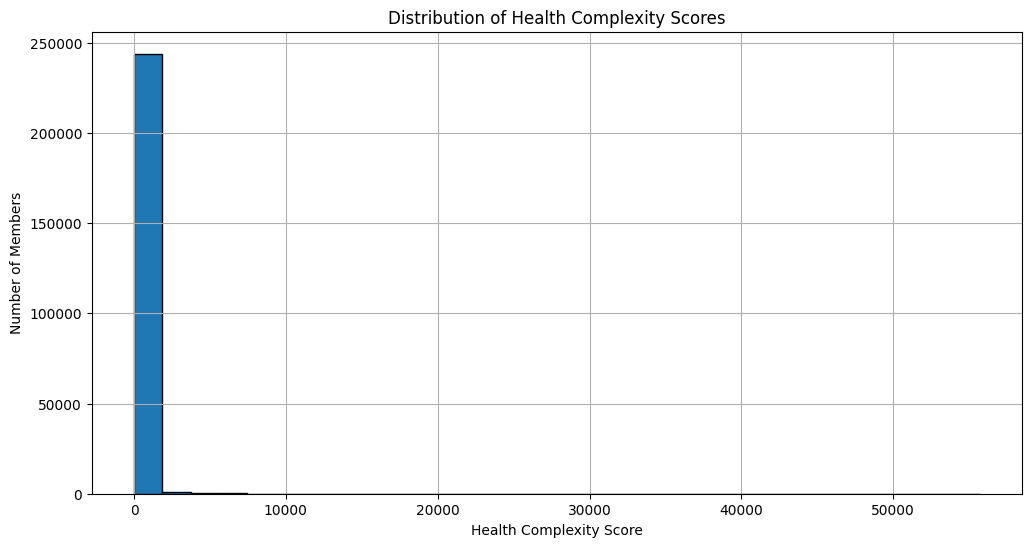

In [42]:
# histogram for the health complexity score distribution
plt.figure(figsize=(12, 6))
plt.hist(health_status_summary['health_complexity_score'], bins=30, edgecolor='black')
plt.title('Distribution of Health Complexity Scores')
plt.xlabel('Health Complexity Score')
plt.ylabel('Number of Members')
plt.grid(True)
plt.show()

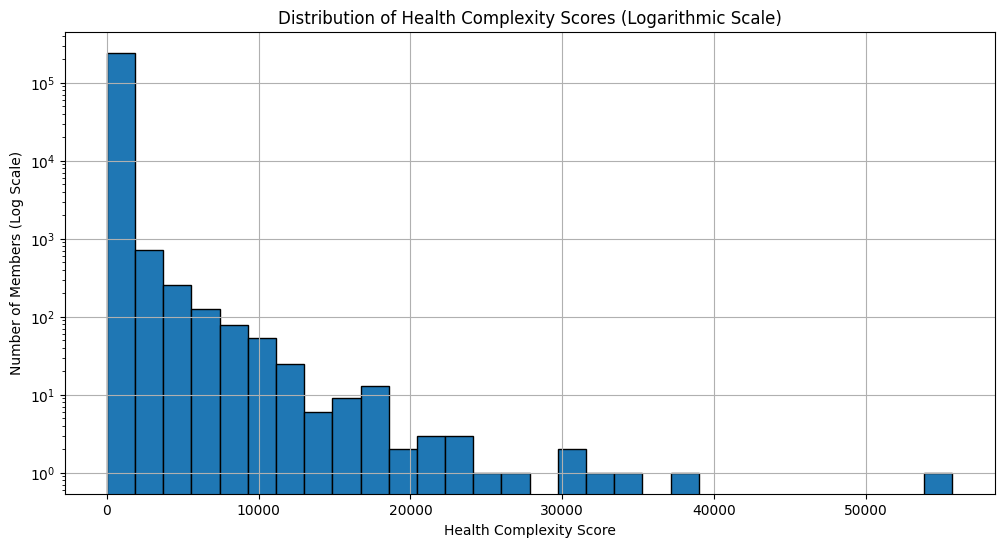

In [43]:
# logarithmic scale
plt.figure(figsize=(12, 6))
plt.hist(health_status_summary['health_complexity_score'], bins=30, edgecolor='black')
plt.yscale('log') 
plt.title('Distribution of Health Complexity Scores (Logarithmic Scale)')
plt.xlabel('Health Complexity Score')
plt.ylabel('Number of Members (Log Scale)')
plt.grid(True)
plt.show()

# Requirement 1

In [44]:
# function to generate a textual health summary for each member
def generate_text_summary(row):
    conditions = ', '.join(set(row['ccs_1_desc'].split(', ') +
                               row['ccs_2_desc'].split(', ') +
                               row['ccs_3_desc'].split(', ')))
    
    prescriptions = row['ndc']
    prescription_text = f"prescribed medications including {prescriptions}" if prescriptions != "No Prescription" else "was not prescribed any medications"

    return f"Member {row['member_id']} has reported health conditions including {conditions}. The member {prescription_text}."

# apply function to the dataframe
health_status_summary['text_summary'] = health_status_summary.apply(generate_text_summary, axis=1)

In [45]:
# adj display settings to see full content
pd.set_option('display.max_colwidth', None)  

health_status_summary[['member_id', 'text_summary']].head(10)

,member_id,text_summary
0,M0000001,"Member M0000001 has reported health conditions including Diseases of the genitourinary system, Other complications of pregnancy, Complications of pregnancy; childbirth; and the puerperium, Menstrual disorders, Diseases of female genital organs, Indications for care in pregnancy; labor; and delivery, Liveborn [218.], Liveborn, Normal pregnancy and/or delivery [196.], Other pregnancy and delivery including normal, Complications mainly related to pregnancy, Certain conditions originating in the perinatal period, Previous C-section. The member was not prescribed any medications."
1,M0000002,"Member M0000002 has reported health conditions including Diseases of the circulatory system, Other lower respiratory disease, Mental Illness, Medical examination/evaluation, Factors influencing health care, Residual codes; unclassified, Residual codes; unclassified; all E codes [259. and 260.], Coronary atherosclerosis and other heart disease, Nonspecific chest pain, Adjustment disorders [650], Adjustment disorders, Other lower respiratory disease [133.], Symptoms; signs; and ill-defined conditions and factors influencing health status, Diseases of the heart, Diseases of the respiratory system, . The member was not prescribed any medications."
2,M0000003,"Member M0000003 has reported health conditions including Diseases of the musculoskeletal system and connective tissue, Acquired deformities, Acquired foot deformities. The member was not prescribed any medications."
3,M0000004,"Member M0000004 has reported health conditions including Immunizations and screening for infectious disease [10.], Medical examination/evaluation, Immunizations and screening for infectious disease, Infectious and parasitic diseases, Symptoms; signs; and ill-defined conditions and factors influencing health status, Factors influencing health care. The member prescribed medications including 58160082152, No Prescription."
4,M0000005,"Member M0000005 has reported health conditions including Headache; including migraine, Headache; including migraine [84.], Diseases of the nervous system and sense organs. The member prescribed medications including 65862059505, 65862059401, No Prescription, 62756052269."
5,M0000006,"Member M0000006 has reported health conditions including Thyroid disorders [48.], Other circulatory disease, Diseases of arteries; arterioles; and capillaries, Other lower respiratory disease, Other lower respiratory disease [133.], Medical examination/evaluation, Other upper respiratory infections, Endocrine; nutritional; and metabolic diseases and immunity disorders, Other upper respiratory disease [134.], Disorders of lipid metabolism [53.], Thyroid disorders, Disorders of lipid metabolism, Symptoms; signs; and ill-defined conditions and factors influencing health status, Nonspecific chest pain, Diseases of the heart, Other upper respiratory disease, Diseases of the respiratory system, Diseases of the circulatory system, Respiratory infections, Factors influencing health care. The member prescribed medications including 68382035405, 60505082901, 51525029403, 93742656, 527134210, No Prescription, 31722025090."
6,M0000007,"Member M0000007 has reported health conditions including Prolonged pregnancy, Other complications of pregnancy, Complications of pregnancy; childbirth; and the puerperium, Diseases of female genital organs, Normal pregnancy and/or delivery [196.], Other congenital anomalies, Other connective tissue disease, Other pregnancy and delivery including normal, , Diseases of the nervous system and sense organs, Diseases of the musculoskeletal system and connective tissue, Other congenital anomalies [217.], Liveborn [218.], Other complications of birth; puerperium affecting management of mother [195.], Other complications of birth; puerperium affecting management of mother, Residual codes; unclassified; all E codes [259. and 260.], Symptoms; signs; and ill-defined conditions and factors influencing health status, O

# Requirement 2

In [46]:
# data prep (Rx features only per the requirement request)
prescription_data = health_status_summary[['member_id','ndc','no_prescription_visits','health_complexity_score']].copy()
prescription_data.head()

,member_id,ndc,no_prescription_visits,health_complexity_score
0,M0000001,No Prescription,213,145.5
1,M0000002,No Prescription,20,58.0
2,M0000003,No Prescription,6,12.0
3,M0000004,"58160082152, No Prescription",2,31.0
4,M0000005,"65862059505, 65862059401, No Prescription, 62756052269",4,55.0


In [47]:
# remove 'No Prescription'
def clean_ndc_column(ndc_value):
    # split on commas, remove 'No Prescription', and join back into a string
    cleaned_ndc = [ndc.strip() for ndc in ndc_value.split(',') if ndc.strip() != 'No Prescription']
    return ', '.join(cleaned_ndc) if cleaned_ndc else None  # Return None if all were removed

prescription_data['ndc'] = prescription_data['ndc'].apply(clean_ndc_column)

# drop rows where ndc is now empty
prescription_data = prescription_data.dropna(subset=['ndc']).reset_index(drop=True)

prescription_data.head()

,member_id,ndc,no_prescription_visits,health_complexity_score
0,M0000004,58160082152,2,31.0
1,M0000005,"65862059505, 65862059401, 62756052269",4,55.0
2,M0000006,"68382035405, 60505082901, 51525029403, 93742656, 527134210, 31722025090",10,132.0
3,M0000007,17478007035,223,245.5
4,M0000008,"59310057922, 68180051703, 43547035611",5,68.5


In [48]:
# split ndc  into individual drug codes
prescription_data['ndc_list'] = prescription_data['ndc'].apply(lambda x: x.split(', '))
prescription_data[['ndc', 'ndc_list']].head()

,ndc,ndc_list
0,58160082152,[58160082152]
1,"65862059505, 65862059401, 62756052269","[65862059505, 65862059401, 62756052269]"
2,"68382035405, 60505082901, 51525029403, 93742656, 527134210, 31722025090","[68382035405, 60505082901, 51525029403, 93742656, 527134210, 31722025090]"
3,17478007035,[17478007035]
4,"59310057922, 68180051703, 43547035611","[59310057922, 68180051703, 43547035611]"


### Note: Initially, I attempted to use the ndc_list as the training data and the health_complexity_score as the target. However, after applying one-hot encoding, the dataset expanded to a shape of (145774, 14286), which was too large for my computer to handle efficiently in a machine learning task. I tested both RandomForestRegressor and XGBoost, but neither converged even after several hours of computation. I also attempted PCA, reducing the number of components to 2500 with an explained variance ratio of 0.87, yet the model still failed to converge. To address this, I chose to reduce the dimensionality by using the drug category data instead of the more granular ndc_list

In [49]:
# new merge to include member_id (for matching) and drug_category
merged_df = prescription_data.merge(
    final_df[['member_id', 'drug_category']], #'drug_category'
    on='member_id', 
    how='left'
)
merged_df.head()

,member_id,ndc,no_prescription_visits,health_complexity_score,ndc_list,drug_category
0,M0000004,58160082152,2,31.0,[58160082152],NaN
1,M0000004,58160082152,2,31.0,[58160082152],NaN
2,M0000004,58160082152,2,31.0,[58160082152],Vaccines
3,M0000005,"65862059505, 65862059401, 62756052269",4,55.0,"[65862059505, 65862059401, 62756052269]",NaN
4,M0000005,"65862059505, 65862059401, 62756052269",4,55.0,"[65862059505, 65862059401, 62756052269]",NaN


In [50]:
# replace missing values with 'Unknown'
merged_df['drug_category'] = merged_df['drug_category'].fillna('Unknown')

In [51]:
# create frequency encoding based on drug_category occurrences
merged_df['drug_category_frequency'] = merged_df.groupby('drug_category')['drug_category'].transform('count')

In [52]:
print(merged_df['drug_category'].value_counts())
print('-'*45)
print(merged_df[['member_id', 'drug_category', 'drug_category_frequency']].head()) 

Unknown                           12597475
Analgesics - Opioid                1124326
Analgesics - Anti-Inflammatory      462114
Cephalosporins                      254331
Dermatologicals                     206354
                                    ...   
Local ANESTHETICS-Parenteral             3
Antacids                                 3
Nutrients                                2
Antiseptics & Disinfectants              1
Chemicals                                1
Name: drug_category, Length: 92, dtype: int64
---------------------------------------------
  member_id drug_category  drug_category_frequency
0  M0000004       Unknown                 12597475
1  M0000004       Unknown                 12597475
2  M0000004      Vaccines                    13596
3  M0000005       Unknown                 12597475
4  M0000005       Unknown                 12597475


In [53]:
merged_df.shape

(17645465, 7)

In [54]:
# convert the column to a list of categoris
merged_df['drug_category_list'] = merged_df['drug_category'].apply(lambda x: [cat.strip() for cat in x.split(',') if cat.strip() != "Unknown"])


In [55]:
# aggregate unique drug categories per Pt into a list 
filtered_df = merged_df.groupby('member_id').agg({         
    'ndc': lambda x: ', '.join(set(x)),
    'no_prescription_visits': 'sum',
    'health_complexity_score': 'mean',
    'ndc_list': lambda x: list(set([item for sublist in x for item in sublist])),
    'drug_category_list': lambda x: list(set([item for sublist in x for item in sublist])),
    'drug_category_frequency': 'sum'  
}).reset_index()


filtered_df.head()

,member_id,ndc,no_prescription_visits,health_complexity_score,ndc_list,drug_category_list,drug_category_frequency
0,M0000004,58160082152,6,31.0,[58160082152],[Vaccines],25208546
1,M0000005,"65862059505, 65862059401, 62756052269",64,55.0,"[65862059505, 65862059401, 62756052269]","[Migraine Products, Anticonvulsants]",51283504
2,M0000006,"68382035405, 60505082901, 51525029403, 93742656, 527134210, 31722025090",260,132.0,"[68382035405, 60505082901, 51525029403, 93742656, 527134210, 31722025090]","[Antiasthmatic and Bronchodilator Agents, Thyroid Agents, Nasal Agents - Systemic and Topical, Antidepressants]",127486915
3,M0000007,17478007035,54412,245.5,[17478007035],[Ophthalmic Agents],2813500450
4,M0000008,"59310057922, 68180051703, 43547035611",50,68.5,"[59310057922, 68180051703, 43547035611]","[Antiasthmatic and Bronchodilator Agents, Antihypertensives]",63569556


# Machine Learning

In [56]:
# one-hot encode the drug_category_list
mlb = MultiLabelBinarizer()

one_hot_encoded = pd.DataFrame(mlb.fit_transform(filtered_df['drug_category_list']),
                               columns=mlb.classes_,
                               index=filtered_df.index)

In [57]:
# concate the one-hot encoded columns with the original dataframe
filtered_df_encoded = pd.concat([filtered_df.drop('drug_category_list', axis=1), one_hot_encoded], axis=1)

In [58]:
filtered_df_encoded.head()

,member_id,ndc,no_prescription_visits,health_complexity_score,ndc_list,drug_category_frequency,Adhd/Anti-narcolepsy/Anti-obesity/Anorexiants,Allergenic Extracts/Biologicals Misc,Aminoglycosides,Analgesics - Anti-Inflammatory,Analgesics - NonNarcotic,Analgesics - Opioid,Androgens-Anabolic,Anorectal Agents,Antacids,Anthelmintics,Anti-Infective Agents - Misc.,Antianginal Agents,Antianxiety Agents,Antiarrhythmics,Antiasthmatic and Bronchodilator Agents,Anticoagulants,Anticonvulsants,Antidepressants,Antidiabetics,Antidiarrheal/Probiotic Agents,Antidotes and Specific Antagonists,Antiemetics,Antifungals,Antihistamines,Antihyperlipidemics,Antihypertensives,Antimalarials,Antimyasthenic/Cholinergic Agents,Antimycobacterial Agents,Antineoplastics and Adjunctive Therapies,Antiparkinson and Related Therapy Agents,Antipsychotics/Antimanic Agents,Antiseptics & Disinfectants,Antivirals,Beta Blockers,Calcium Channel Blockers,Cardiotonics,Cardiovascular Agents - Misc.,Cephalosporins,Chemicals,Contraceptives,Corticosteroids,Cough/Cold/Allergy,Dermatologicals,Diagnostic Products,Dietary Products/Dietary Management Products,Digestive Aids,Diuretics,Endocrine and Metabolic Agents - Misc.,Estrogens,Fluoroquinolones,Gastrointestinal Agents - Misc.,General Anesthetics,Genitourinary Agents - Miscellaneous,Gout Agents,Hematological Agents - Misc.,Hematopoietic Agents,Hemostatics,Hypnotics/Sedatives/Sleep Disorder Agents,Laxatives,Local ANESTHETICS-Parenteral,Macrolides,Medical Devices and Supplies,Migraine Products,Minerals & Electrolytes,Miscellaneous Therapeutic Classes,Mouth/Throat/Dental Agents,Multivitamins,Musculoskeletal Therapy Agents,Nasal Agents - Systemic and Topical,Neuromuscular Agents,Nutrients,Ophthalmic Agents,Otic Agents,Oxytocics,Passive Immunizing and Treatment Agents,Penicillins,Pharmaceutical Adjuvants,Progestins,Psychotherapeutic and Neurological Agents - Misc.,Respiratory Agents - Misc.,Tetracyclines,Thyroid Agents,Toxoids,Ulcer Drugs,Urinary Anti-Infectives,Urinary Antispasmodics,Vaccines,Vaginal Products,Vasopressors,Vitamins
0,M0000004,58160082152,6,31.0,[58160082152],25208546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,M0000005,"65862059505, 65862059401, 62756052269",64,55.0,"[65862059505, 65862059401, 62756052269]",51283504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M0000006,"68382035405, 60505082901, 51525029403, 93742656, 527134210, 31722025090",260,132.0,"[68382035405, 60505082901, 51525029403, 93742656, 527134210, 31722025090]",127486915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,M0000007,17478007035,54412,245.5,[17478007035],2813500450,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M0000008,"59310057922, 68180051703, 43547035611",50,68.5,"[59310057922, 68180051703, 43547035611]",63569556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Note: original shape of the one-hot encoded ndc_list data was (145774, 14286), now we are (145774, 541) after switching to drug_class, and (145774, 92) for drug_category **

In [59]:
X = filtered_df_encoded.drop(columns=['member_id', 'ndc', 'ndc_list',  'health_complexity_score']) 
y = filtered_df['health_complexity_score']

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

In [61]:
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 35491.49
Root Mean Squared Error: 188.39
Mean Absolute Error: 26.54
R² Score: 0.92


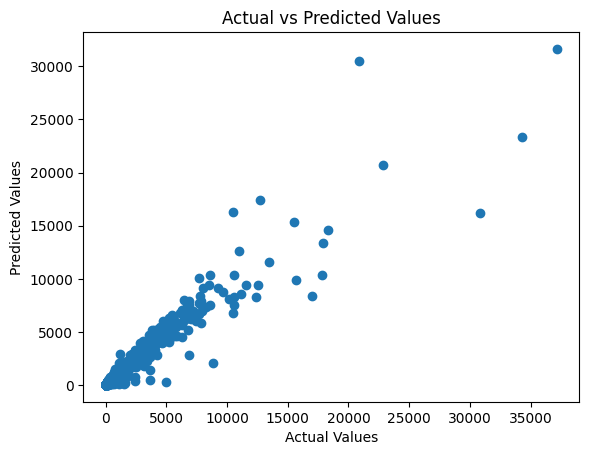

In [62]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

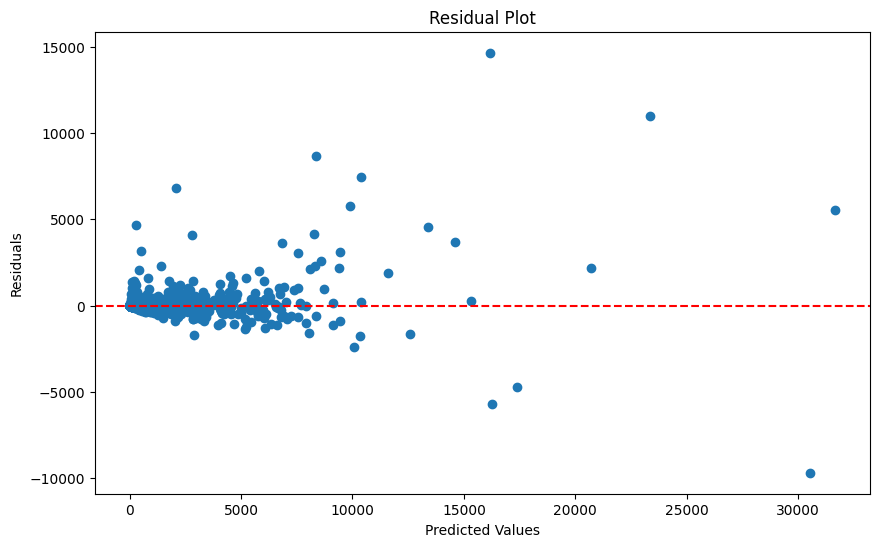

In [63]:
# residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [64]:
# feature importance
importances = regressor.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
0,no_prescription_visits,0.831218
1,drug_category_frequency,0.107614
7,Analgesics - Opioid,0.016661
40,Cephalosporins,0.003810
66,Minerals & Electrolytes,0.003086
19,Antidepressants,0.002381
20,Antidiabetics,0.002197
6,Analgesics - NonNarcotic,0.001811
18,Anticonvulsants,0.001641
81,Psychotherapeutic and Neurological Agents - Misc.,0.001415
